In [ ]:
%pip install --upgrade scikit-image opencv-python-headless matplotlib scikit-learn Pillow pandas


In [ ]:
%pip install colormath


  Preparing metadata (setup.py) ... done
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39405 sha256=6de09ad4bddcc0f8011cb12003850d251870b42d4fbe6db51ef1b4622b0a1a60
  Stored in directory: /root/.cache/pip/wheels/9a/32/6a/605739a172d8112031c9875d744aef91709f00de9b3bbb9274
Successfully built colormath


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()


In [ ]:
import os

IMAGE_DIR =  '/content/drive/MyDrive/DominantColors/images'
RESULT_DIR = '/content/drive/MyDrive/DominantColors/results'

os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

print("Image directory:", IMAGE_DIR)
print("Result directory:", RESULT_DIR)






Image directory: /content/drive/MyDrive/DominantColors/images
Result directory: /content/drive/MyDrive/DominantColors/results


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io, color
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import slic
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import pandas as pd
import cv2
from skimage.color import rgb2lab, lab2rgb, lab2lch
from skimage.morphology import erosion, square
from skimage.graph import rag_mean_color
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic
from skimage import segmentation
from skimage.filters import gaussian


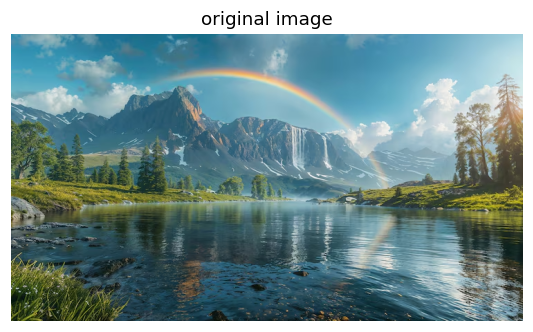

In [ ]:


path = '/content/drive/MyDrive/DominantColors/images/4.jpg'


plt.rcParams['figure.dpi'] = 110

# load image (returns float RGB in 0..1)
def load_image(path, max_side=900):
    img = io.imread(path)
    if img.dtype == np.uint8:
        img = img.astype(np.float32) / 255.0
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]
    h,w = img.shape[:2]
    if max(h,w) > max_side:
        scale = max_side/max(h,w)
        new_w, new_h = int(w*scale), int(h*scale)
        img = cv2.resize((img*255).astype('uint8'), (new_w, new_h), interpolation=cv2.INTER_AREA).astype(np.float32)/255.0
    return img

def show_image(img, title=None):
    plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis('off')
    if title: plt.title(title)
    plt.show()


def show_palette(colors, title=None, w=400, h=60):
    n = len(colors)
    palette = np.zeros((h,w,3), dtype=np.float32)
    for i, c in enumerate(colors):
        start = int(i*w/n)
        end = int((i+1)*w/n)
        palette[:, start:end, :] = c
    show_image(palette, title)



img = load_image(path)
show_image(img, "original image")





## RGB-Based Dominant Color Extraction Method

In [ ]:
def dominant_colors_rgb(img, k=5, sample_size=10000, random_state=42):
    # Flatten image to pixels
    pixels = img.reshape(-1, 3)

    # Subsample for speed (reproducible)
    rng = np.random.default_rng(random_state)
    if len(pixels) > sample_size:
        idx = rng.choice(len(pixels), sample_size, replace=False)
        pixels_sample = pixels[idx]
    else:
        pixels_sample = pixels

    # K-means in RGB space
    kmeans = KMeans(
        n_clusters=k,
        random_state=random_state,
        n_init=10
    ).fit(pixels_sample)

    # assign all pixels to clusters
    labels = kmeans.predict(pixels)
    counts = np.bincount(labels)

    # sorting clusters by frequency
    order = np.argsort(-counts)
    colors = kmeans.cluster_centers_[order]
    proportions = counts[order] / counts.sum()

    # convert colors from [0,1] to [0,255]
    colors = np.clip(colors * 255, 0, 255).astype(np.uint8)

    return colors, proportions


In [ ]:
def show_palette_proportions(colors, proportions, title):
    fig, ax = plt.subplots(figsize=(6, 1))
    start = 0

    for color, prop in zip(colors, proportions):
        ax.add_patch(
            plt.Rectangle((start, 0), prop, 1, color=color / 255)
        )
        start += prop

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title(title)
    plt.show()


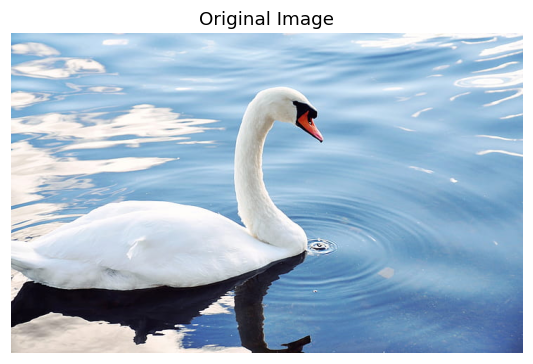

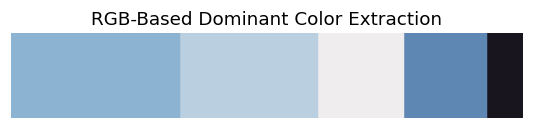

In [ ]:
img = load_image(path)
show_image(img, "Original Image")

colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")


## CIELAB-Based Dominant Colors
CIELAB-based dominant color extraction using K-means clustering, where pixel colors are grouped in a perceptually uniform color space and dominant colors are selected based on cluster frequency.

In [ ]:
def dominant_colors_cielab(img, k=5, sample_size=15000, random_state=42):


    # convert RGB to CIELAB
    lab = rgb2lab(img)
    pixels = lab.reshape(-1, 3)

    # Subsample pixels for efficiency
    N = pixels.shape[0]
    if N > sample_size:
        idx = np.random.choice(N, sample_size, replace=False)
        pixels_sample = pixels[idx]
    else:
        pixels_sample = pixels

    # K-means clustering in LAB space
    kmeans = KMeans(
        n_clusters=k,
        random_state=random_state,
        n_init=10
    )
    kmeans.fit(pixels_sample)

    centers_lab = kmeans.cluster_centers_

    # Assign all pixels to nearest cluster center
    labels_full = kmeans.predict(pixels)

    # Count cluster sizes (frequency-based dominance)
    counts = np.bincount(labels_full, minlength=k)

    # Sort clusters by dominance
    order = np.argsort(-counts)
    centers_lab = centers_lab[order]

    # Convert LAB centers back to RGB
    centers_rgb = lab2rgb(centers_lab.reshape(1, -1, 3)).reshape(-1, 3)
    centers_rgb = np.clip(centers_rgb, 0, 1)

    return centers_rgb, counts[order]


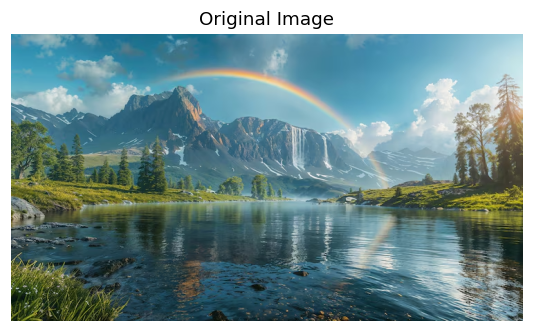

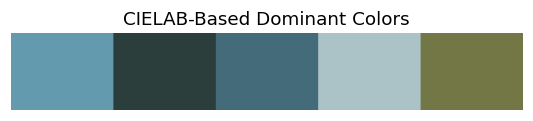

In [ ]:

img = load_image(path)
show_image(img, "Original Image")

colors_lab, counts_lab = dominant_colors_cielab(img, k=5)

show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



## Chang & Mukai (2022) method: feature dominant color extraction

---



In [ ]:
def itti_style_attention_map(img_rgb, n_scales=6):

    img = np.clip(img_rgb, 0, 1).astype(np.float32)
    H, W = img.shape[:2]

    # Intensity
    I = rgb2gray(img).astype(np.float32)

    # Color opponent channels
    R, G, B = img[...,0], img[...,1], img[...,2]
    RG = R - G
    BY = B - 0.5*(R + G)

    def pyramid(x):
        pyr = [x]
        for _ in range(1, n_scales):
            x = cv2.pyrDown(x)
            pyr.append(x)
        return pyr

    def center_surround(pyr):
        maps = []
        for c in range(len(pyr) - 2):
            s = c + 2
            center = pyr[c]
            surround = cv2.resize(
                pyr[s],
                (center.shape[1], center.shape[0]),
                interpolation=cv2.INTER_LINEAR
            )
            maps.append(np.abs(center - surround))
        return maps

    maps_I  = center_surround(pyramid(I))
    maps_RG = center_surround(pyramid(RG))
    maps_BY = center_surround(pyramid(BY))

    def norm01(x):
        x = x - x.min()
        return x / (x.max() - x.min() + 1e-12)

    sal = np.zeros((H, W), dtype=np.float32)

    # Normalize + resize each map before summing
    for m in (maps_I + maps_RG + maps_BY):
        m_norm = norm01(m)
        m_resized = cv2.resize(m_norm, (W, H), interpolation=cv2.INTER_LINEAR)
        sal += m_resized

    sal = norm01(sal)
    return sal


In [ ]:
def merge_rag_by_lab(labels, lab_img, thresh=8.0):


    rag = rag_mean_color(lab_img, labels, mode='distance')
    labels_out = labels.copy()

    # Iteratively merge edges under threshold
    merged = True
    while merged:
        merged = False
        # find smallest edge
        min_edge = None
        min_w = 1e9
        for n1, n2, data in rag.edges(data=True):
            w = data.get('weight', 1e9)
            if w < min_w:
                min_w = w
                min_edge = (n1, n2)

        if min_edge is not None and min_w < thresh:
            n1, n2 = min_edge
            # merge n2 into n1 by relabeling
            labels_out[labels_out == n2] = n1
            # rebuild rag after merge
            rag = rag_mean_color(lab_img, labels_out, mode='distance')
            merged = True

    # compress labels to 0..K-1
    uniq = np.unique(labels_out)
    remap = {old:i for i, old in enumerate(uniq)}
    labels_out = np.vectorize(remap.get)(labels_out)
    return labels_out


In [ ]:
def remove_boundary_mixing_clusters(labels, erosion_size=3):

    K = labels.max() + 1
    keep = np.ones(K, dtype=bool)

    se = square(erosion_size)
    for k in range(K):
        mk = (labels == k).astype(np.uint8)
        er = erosion(mk, se)
        if er.sum() == 0:
            keep[k] = False

    # remap labels to kept-only
    mapping = {}
    new_id = 0
    for k in range(K):
        if keep[k]:
            mapping[k] = new_id
            new_id += 1

    labels_new = labels.copy()
    labels_new[~np.isin(labels_new, np.where(keep)[0])] = -1
    mask_valid = (labels_new >= 0)
    labels_new[mask_valid] = np.vectorize(mapping.get)(labels_new[mask_valid])

    return labels_new, keep


In [ ]:
def compute_cluster_features(img_rgb, lab_img, labels, attention_map):

    # Compute Ck, Ak, Sk, pk for each cluster following the paper.

    H, W = labels.shape
    valid = (labels >= 0)
    K = labels[valid].max() + 1 if valid.any() else 0

    # cluster LAB centers (mean LAB of pixels)
    centers_lab = np.zeros((K, 3), dtype=np.float32)
    Ck = np.zeros(K, dtype=np.float32)
    Ak = np.zeros(K, dtype=np.float32)
    Sk = np.zeros(K, dtype=np.float32)

    for k in range(K):
        m = (labels == k)
        nk = m.sum()
        if nk == 0:
            continue
        centers_lab[k] = lab_img[m].mean(axis=0)
        Ck[k] = attention_map[m].mean()
        Ak[k] = nk
        a, b = centers_lab[k, 1], centers_lab[k, 2]
        Sk[k] = np.sqrt(a*a + b*b)

    # normalize Ak, Sk by max as in paper
    if Ak.max() > 0:
        Ak = Ak / Ak.max()
    if Sk.max() > 0:
        Sk = Sk / Sk.max()

    pk = Ck + Ak + Sk  # Eq. (5)
    return centers_lab, Ck, Ak, Sk, pk


In [ ]:
def lab_hue_angle(lab):
    a, b = lab[1], lab[2]
    ang = np.arctan2(b, a)  # [-pi, pi]
    return ang

def deltaE76(lab1, lab2):
    return np.linalg.norm(lab1 - lab2)

def select_final_colors_chang_mukai(centers_lab, Ck, Ak, Sk, pk, final_k=5):

    K = len(pk)
    if K == 0:
        return []

    selected = []
    remaining = list(range(K))

    # helper: compute sigmas over remaining
    def sigmas():
        if len(remaining) < 2:
            return 1.0, 1.0
        hues = np.array([lab_hue_angle(centers_lab[i]) for i in remaining])
        # pairwise hue diffs and deltaE diffs (approx for sigma)
        hue_diffs = []
        de_diffs = []
        for i in range(len(remaining)):
            for j in range(i+1, len(remaining)):
                di = remaining[i]; dj = remaining[j]
                dh = np.abs(hues[i] - hues[j])
                dh = min(dh, 2*np.pi - dh)
                hue_diffs.append(dh)
                de_diffs.append(deltaE76(centers_lab[di], centers_lab[dj]))
        sh = np.std(hue_diffs) + 1e-6
        sc = np.std(de_diffs) + 1e-6
        return sh, sc


    d1 = int(np.argmax(Sk))
    selected.append(d1)
    if d1 in remaining: remaining.remove(d1)


    if len(selected) < final_k and len(remaining) > 0:
        d2 = int(remaining[np.argmax([Ak[i] for i in remaining])])
        selected.append(d2)
        remaining.remove(d2)

    # update weights after selecting a color
    def apply_weight_update(d):
        nonlocal Ck, Ak, Sk, pk
        sh, sc = sigmas()
        hd = lab_hue_angle(centers_lab[d])

        for k in remaining:
            hk = lab_hue_angle(centers_lab[k])
            dh = np.abs(hd - hk)
            dh = min(dh, 2*np.pi - dh)

            dc = deltaE76(centers_lab[d], centers_lab[k])

            w1 = 1.0 - np.exp(-0.5 * (dh / sh)**2)
            w2 = 1.0 - np.exp(-0.5 * (dc / sc)**2)
            w = w1 * w2

            Ck[k] *= w
            Ak[k] *= w
            Sk[k] *= w
            pk[k] *= w

    # update after initial picks
    for d in selected:
        apply_weight_update(d)

    # pick by pk until final_k reached
    while len(selected) < final_k and len(remaining) > 0:
        d = int(remaining[np.argmax([pk[i] for i in remaining])])
        selected.append(d)
        remaining.remove(d)
        apply_weight_update(d)

    return selected


In [ ]:
def chang_mukai_palette(img_rgb,
                        large_k=35,
                        final_k=5,
                        bilateral_d=7,
                        bilateral_sigma_color=20,
                        bilateral_sigma_space=7,
                        rag_thresh=8.0,
                        erosion_size=3,
                        random_state=42):


    img = np.clip(img_rgb, 0, 1).astype(np.float32)

    # bilateral filter (applied in CIELAB in the paper)
    lab = rgb2lab(img).astype(np.float32)
    lab_f = lab.copy()
    for ch in range(3):

        chan = lab[..., ch]
        cmin, cmax = chan.min(), chan.max()
        norm = (chan - cmin) / (cmax - cmin + 1e-12)
        norm8 = (norm * 255).astype(np.uint8)
        bf = cv2.bilateralFilter(norm8, d=bilateral_d,
                                 sigmaColor=bilateral_sigma_color,
                                 sigmaSpace=bilateral_sigma_space).astype(np.float32) / 255.0
        lab_f[..., ch] = bf * (cmax - cmin) + cmin

    #  large-K K-means in CIELAB
    pixels = lab_f.reshape(-1, 3)
    km = KMeans(n_clusters=large_k, random_state=random_state, n_init=10, init="k-means++")
    labels = km.fit_predict(pixels).reshape(lab_f.shape[:2])

    # enforce image-space coherency: RAG-based merging
    labels = merge_rag_by_lab(labels, lab_f, thresh=rag_thresh)

    # compute attention map (Itti-style)
    att = itti_style_attention_map(img)

    # remove boundary/mixing clusters via erosion
    labels2, keep = remove_boundary_mixing_clusters(labels, erosion_size=erosion_size)

    # compute features: contrast, area, saturation; pk=C+A+S
    centers_lab, Ck, Ak, Sk, pk = compute_cluster_features(img, lab_f, labels2, att)

    # select final colors (paper: 5 colors)
    selected_ids = select_final_colors_chang_mukai(centers_lab, Ck, Ak, Sk, pk, final_k=final_k)

    # convert selected LAB centers to RGB
    selected_lab = centers_lab[selected_ids]
    colors_rgb = lab2rgb(selected_lab.reshape(1, -1, 3)).reshape(-1, 3)
    colors_rgb = np.clip(colors_rgb, 0, 1)
    return colors_rgb


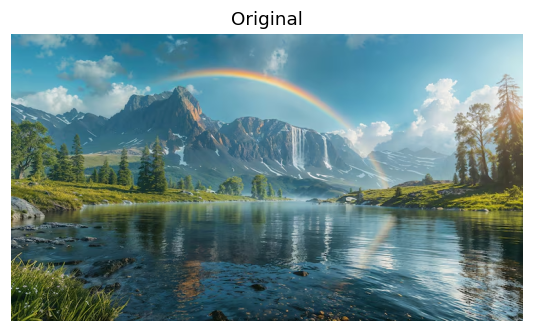

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


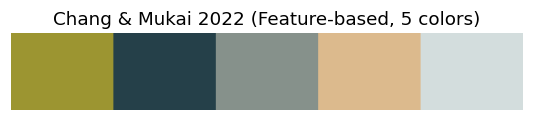

In [ ]:
img = load_image(path)
show_image(img, "Original")


cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")


## HPD-DCE

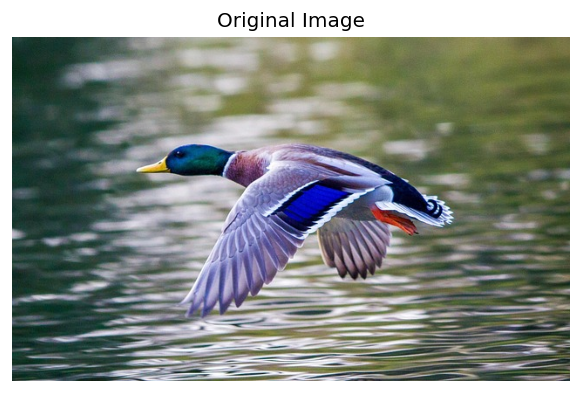

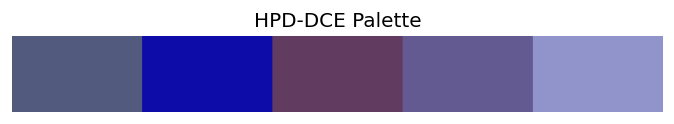

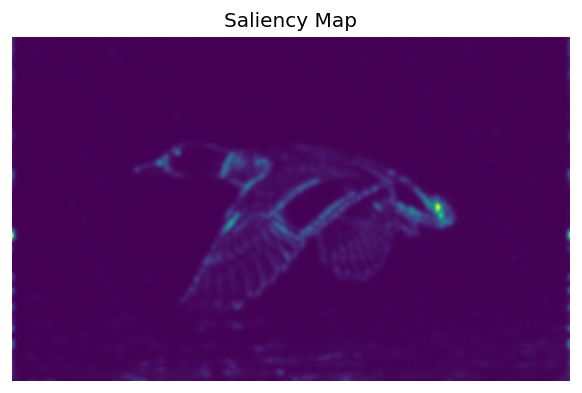

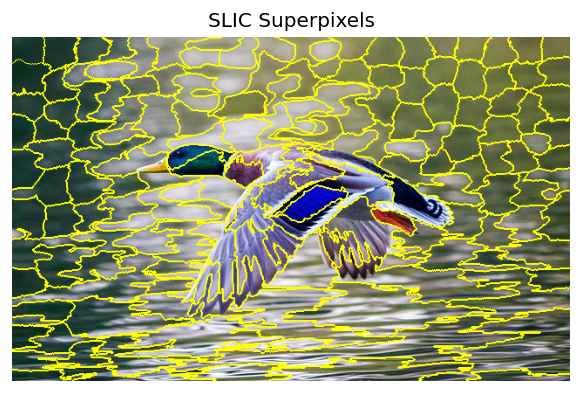

In [ ]:
plt.rcParams["figure.dpi"] = 120


# Image loading and preprocessing

def load_image(path, max_side=900):
    img = io.imread(path)

    # Ensure RGB
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    if img.shape[-1] == 4:
        img = img[..., :3]

    # Normalize to [0,1]
    if img.dtype == np.uint8:
        img = img.astype(np.float32) / 255.0
    else:
        img = np.clip(img.astype(np.float32), 0, 1)

    # Resize if needed
    h, w = img.shape[:2]
    if max(h, w) > max_side:
        scale = max_side / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        img = cv2.resize(
            (img * 255).astype(np.uint8),
            (new_w, new_h),
            interpolation=cv2.INTER_AREA
        ).astype(np.float32) / 255.0

    return img


def show_image(img, title=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.imshow(np.clip(img, 0, 1))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


def show_palette_equal(colors_rgb_uint8, title="Palette", w=600, h=70):
    n = len(colors_rgb_uint8)
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    for i, c in enumerate(colors_rgb_uint8):
        a = int(i * w / n)
        b = int((i + 1) * w / n)
        canvas[:, a:b, :] = c
    show_image(canvas.astype(np.float32) / 255.0, title=title, figsize=(7,1.2))


# Saliency estimation (Hou & Zhang spectral residual)

def spectral_residual_saliency(img_rgb01, blur_sigma=2.5):
    gray = (
        0.2989 * img_rgb01[..., 0] +
        0.5870 * img_rgb01[..., 1] +
        0.1140 * img_rgb01[..., 2]
    ).astype(np.float32)

    F = np.fft.fft2(gray)
    A = np.abs(F) + 1e-8
    P = np.angle(F)

    logA = np.log(A)
    avg = cv2.blur(logA.astype(np.float32), (3, 3))
    R = logA - avg

    S = np.abs(np.fft.ifft2(np.exp(R + 1j * P)))**2
    S = gaussian(S, sigma=blur_sigma, preserve_range=True)

    S -= S.min()
    if S.max() > 1e-8:
        S /= S.max()

    return S.astype(np.float32)


# HPD-DCE  algorithm

def deltaE76(lab1, lab2):
    return float(np.sqrt(np.sum((lab1 - lab2) ** 2)))


def hpd_dce(
    img_rgb01,
    k=10,
    slic_n_segments=250,
    slic_compactness=10,
    de_thresh=12.0,
    weights=(0.4, 0.3, 0.1, 0.2)
):


    wS, wC, wD, wA = weights

    # convert to CIELAB
    img_lab = color.rgb2lab(img_rgb01).astype(np.float32)

    # compute saliency map
    saliency = spectral_residual_saliency(img_rgb01)

    # Superpixel segmentation
    segments = segmentation.slic(
        img_rgb01,
        n_segments=slic_n_segments,
        compactness=slic_compactness,
        start_label=0,
        channel_axis=-1
    )


    global_lab = img_lab.reshape(-1, 3).mean(axis=0)
    total_pixels = img_rgb01.shape[0] * img_rgb01.shape[1]

    region_features = []
    region_colors = []

    # region level feature extraction
    for rid in np.unique(segments):
        mask = (segments == rid)
        area = mask.sum() / total_pixels

        lab_vals = img_lab[mask]
        mean_lab = lab_vals.mean(axis=0)

        a, b = mean_lab[1], mean_lab[2]
        chroma = np.sqrt(a*a + b*b)

        mean_sal = saliency[mask].mean()
        distinctiveness = np.linalg.norm(mean_lab - global_lab)

        region_features.append([mean_sal, chroma, distinctiveness, area])
        region_colors.append(mean_lab)

    region_features = np.array(region_features, dtype=np.float32)
    region_colors = np.array(region_colors, dtype=np.float32)

    # Normalize features
    def norm01(x):
        if x.max() - x.min() < 1e-8:
            return np.zeros_like(x)
        return (x - x.min()) / (x.max() - x.min())

    S = norm01(region_features[:, 0])
    C = norm01(region_features[:, 1])
    D = norm01(region_features[:, 2])
    A = norm01(region_features[:, 3])

    # perception based scoring
    scores = wS*S + wC*C + wD*D + wA*A
    order = np.argsort(-scores)

    candidates = region_colors[order]

    # delat E diversity filtering
    selected = []
    for col in candidates:
        if len(selected) == 0 or all(deltaE76(col, s) >= de_thresh for s in selected):
            selected.append(col)
        if len(selected) >= k:
            break

    palette_lab = np.array(selected, dtype=np.float32)


    palette_rgb = np.clip(
        color.lab2rgb(palette_lab.reshape(1, -1, 3)).reshape(-1, 3),
        0, 1
    )
    palette_rgb_uint8 = (palette_rgb * 255).astype(np.uint8)

    debug = {
        "saliency": saliency,
        "segments": segments,
        "scores": scores
    }

    return palette_lab, palette_rgb_uint8, debug




img = load_image('/content/drive/MyDrive/DominantColors/images/9.jpg')
show_image(img, "Original Image")

palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)


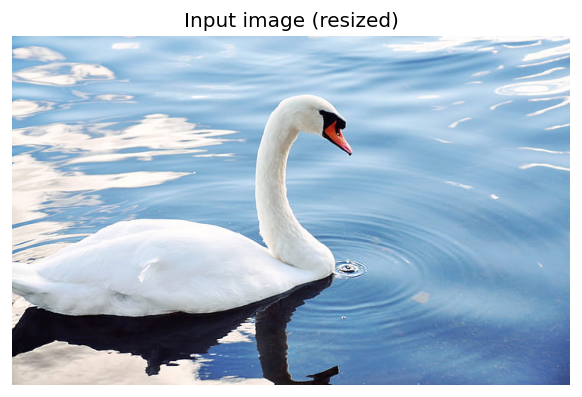

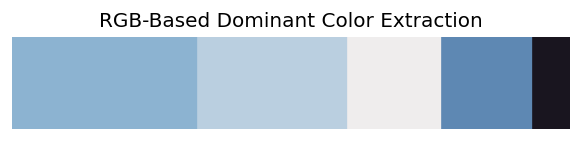

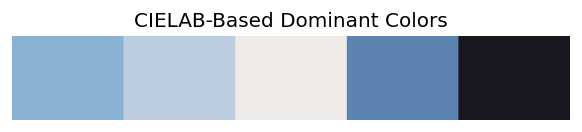

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


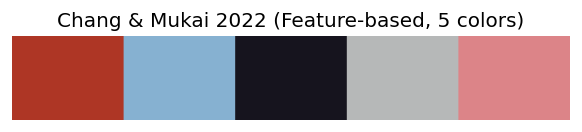

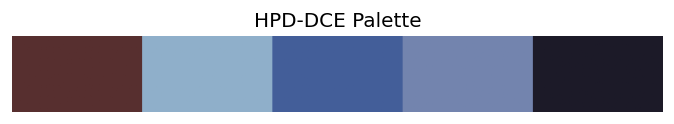

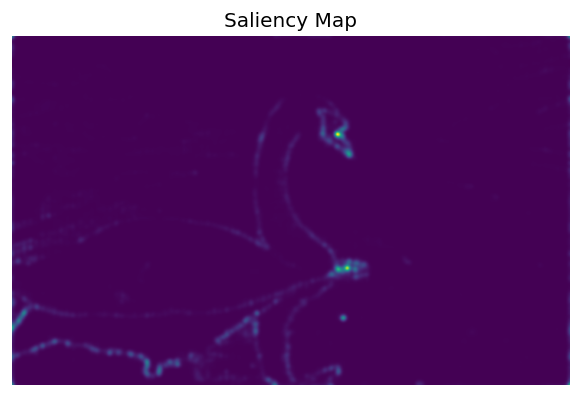

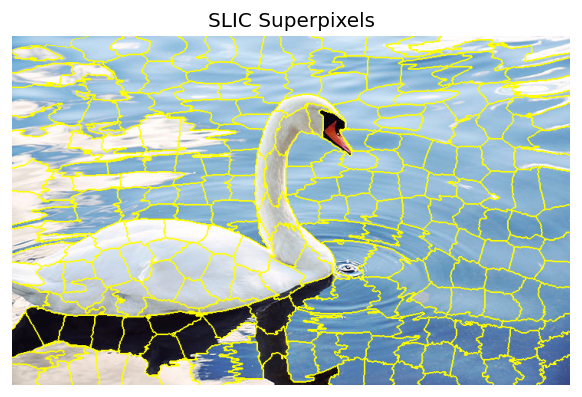

In [ ]:
image_path = '/content/drive/MyDrive/DominantColors/images/8.jpg'

img = load_image(image_path)
show_image(img, 'Input image (resized)')


colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")




colors_lab, counts_lab = dominant_colors_cielab(img, k=5)
show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")



palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)


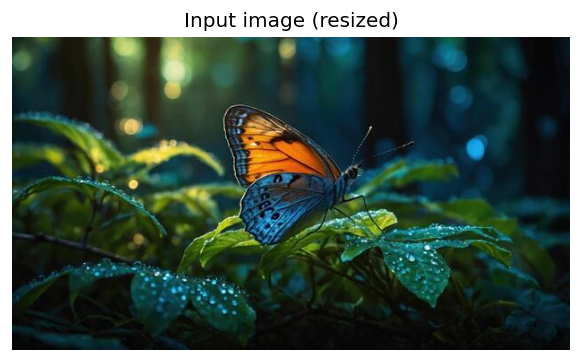

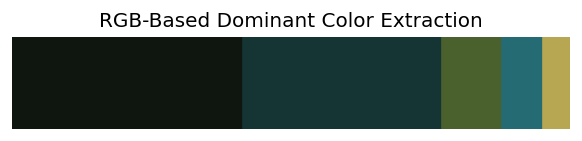

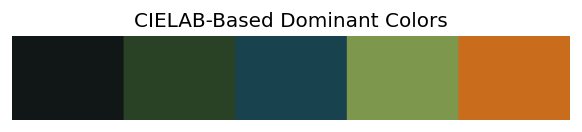

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


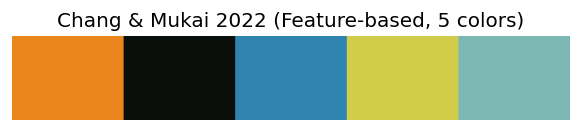

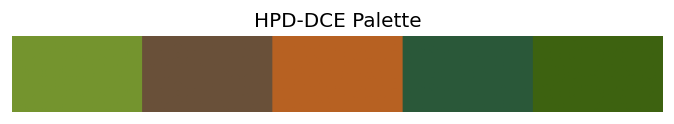

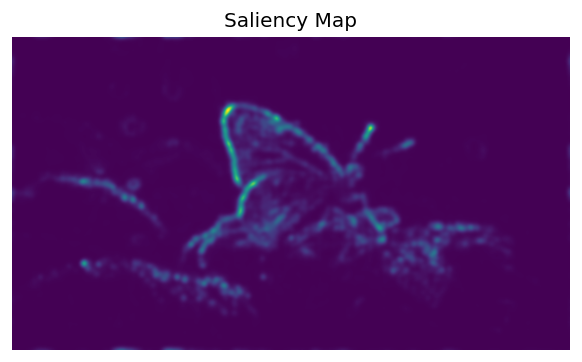

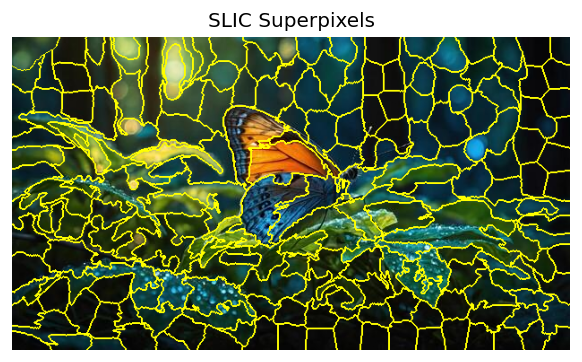

In [ ]:
image_path = '/content/drive/MyDrive/DominantColors/images/3.jpg'

img = load_image(image_path)
show_image(img, 'Input image (resized)')


colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")




colors_lab, counts_lab = dominant_colors_cielab(img, k=5)
show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")



palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)


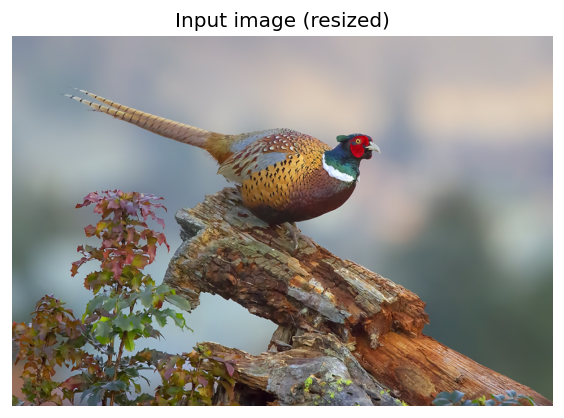

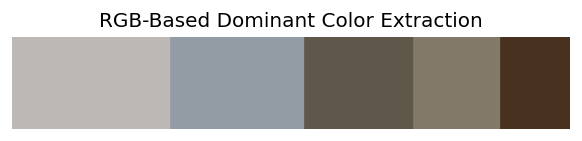

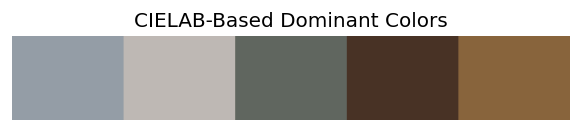

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


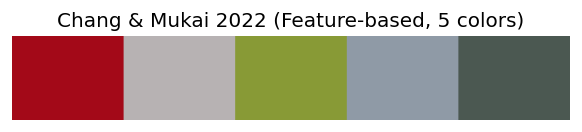

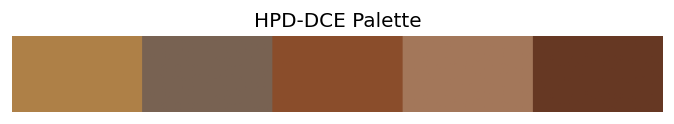

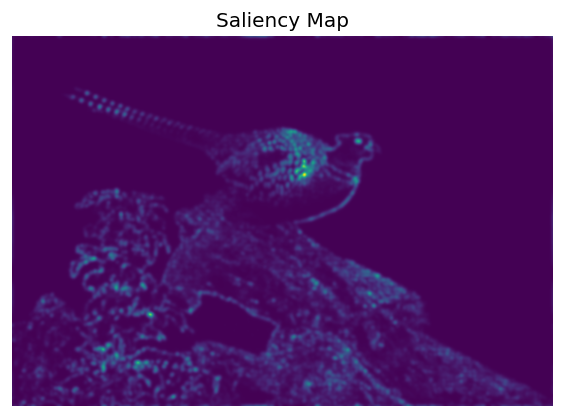

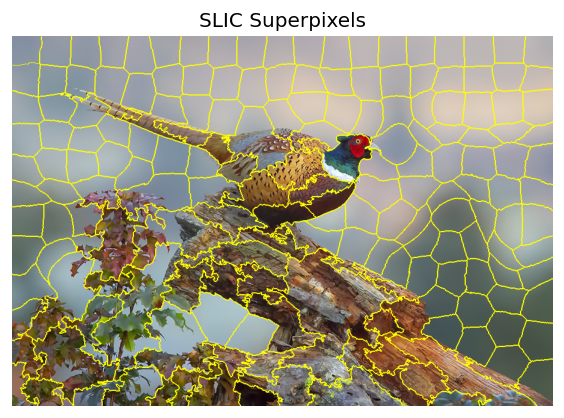

In [ ]:
image_path = '/content/drive/MyDrive/DominantColors/images/1.jpg'

img = load_image(image_path)
show_image(img, 'Input image (resized)')


colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")




colors_lab, counts_lab = dominant_colors_cielab(img, k=5)
show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")



palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)


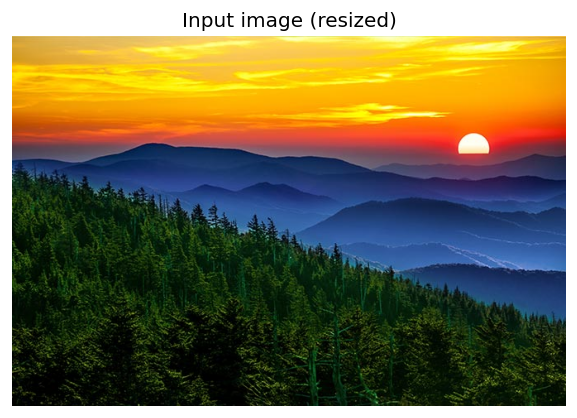

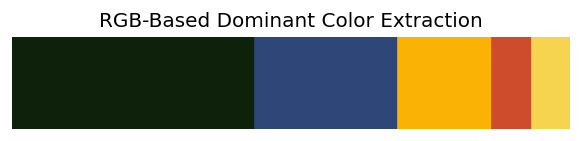

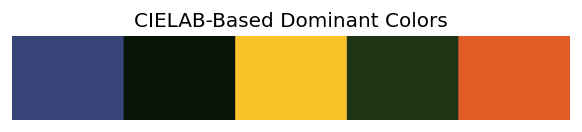

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


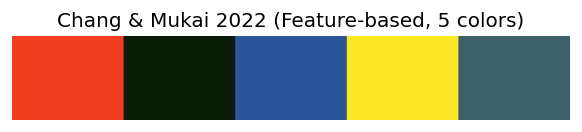

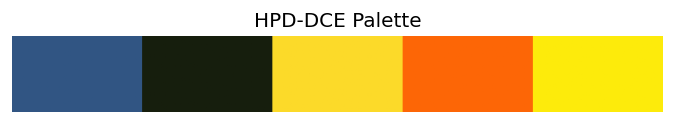

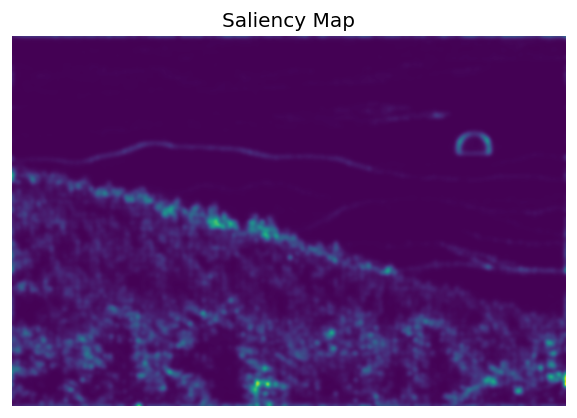

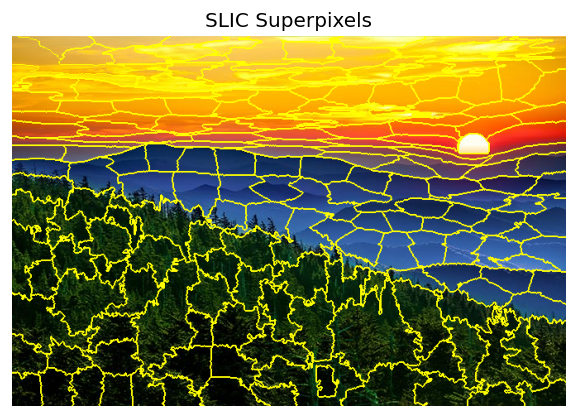

In [ ]:
image_path = '/content/drive/MyDrive/DominantColors/images/2.jpg'

img = load_image(image_path)
show_image(img, 'Input image (resized)')


colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")




colors_lab, counts_lab = dominant_colors_cielab(img, k=5)
show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")



palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)


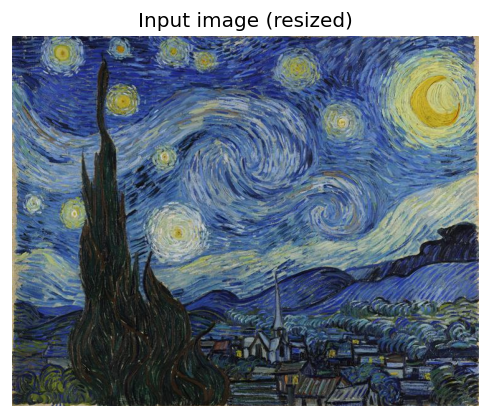

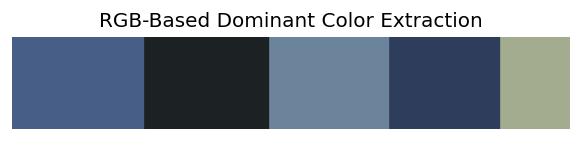

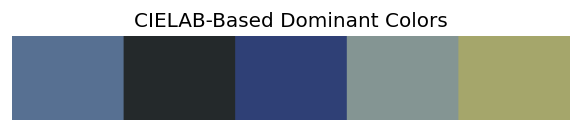

/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


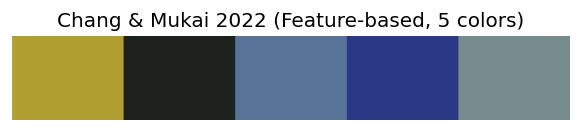

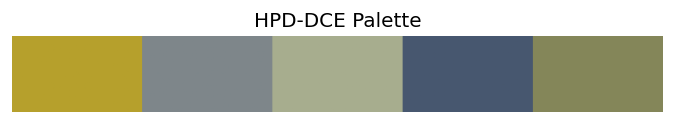

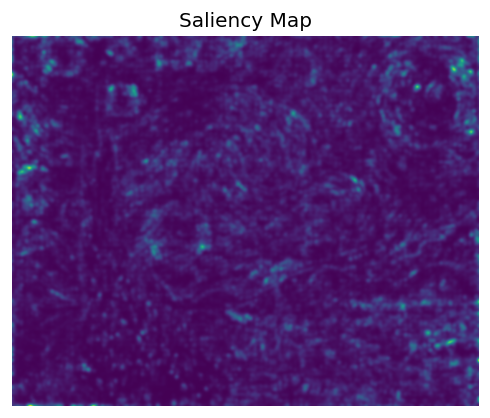

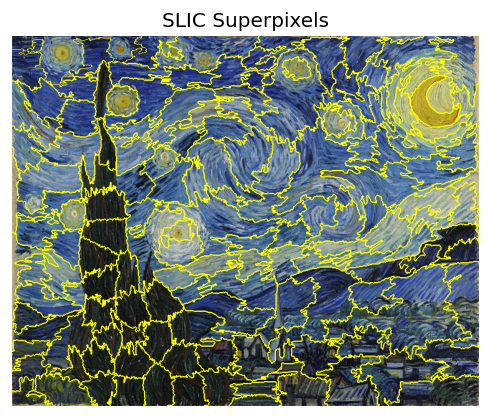

In [ ]:
image_path = '/content/drive/MyDrive/DominantColors/images/The-Starry-Night.jpg'

img = load_image(image_path)
show_image(img, 'Input image (resized)')


colors, proportions = dominant_colors_rgb(img, k=5)
show_palette_proportions(colors, proportions, "RGB-Based Dominant Color Extraction")




colors_lab, counts_lab = dominant_colors_cielab(img, k=5)
show_palette(colors_lab, title="CIELAB-Based Dominant Colors")



cm_cols = chang_mukai_palette(img, large_k=35, final_k=5)
show_palette(cm_cols, "Chang & Mukai 2022 (Feature-based, 5 colors)")



palette_lab, palette_rgb, dbg = hpd_dce(img, k=5)

show_palette_equal(palette_rgb, "HPD-DCE Palette")
show_image(dbg["saliency"], "Saliency Map")
show_image(
    segmentation.mark_boundaries(img, dbg["segments"]),
    "SLIC Superpixels"
)




---



In [ ]:
from matplotlib.patches import Rectangle

def draw_palette(ax, palette, title):
    ax.axis("off")
    n = len(palette)
    for i, color in enumerate(palette):
        ax.add_patch(
            Rectangle(
                (i / n, 0), 1 / n, 1,
                transform=ax.transAxes,
                facecolor=color,
                edgecolor="none"
            )
        )
    ax.set_title(title, fontsize=10)


In [ ]:

def normalize_palette(palette):
    palette = np.asarray(palette, dtype=float)
    if palette.max() > 1.0:
        palette = palette / 255.0
    return palette


In [ ]:
from skimage import segmentation

def process_single_image(img, img_name, save_path, k=5):
    # apply all methods
    rgb_cols, _ = dominant_colors_rgb(img, k=k)
    lab_cols, _ = dominant_colors_cielab(img, k=k)
    cm_cols = chang_mukai_palette(img, large_k=35, final_k=k)
    _, hpd_rgb, dbg = hpd_dce(img, k=k)



        # Normalize ALL palettes
    rgb_cols = normalize_palette(rgb_cols)
    lab_cols = normalize_palette(lab_cols)
    cm_cols  = normalize_palette(cm_cols)
    hpd_rgb  = normalize_palette(hpd_rgb)



    # Create figure
    fig, axs = plt.subplots(1, 5, figsize=(16, 3))

    axs[0].imshow(img)
    axs[0].axis("off")
    axs[0].set_title("Image")

    draw_palette(axs[1], rgb_cols, "Baseline RGB")
    draw_palette(axs[2], lab_cols, "KMeans (CIELAB)")
    draw_palette(axs[3], cm_cols, "Feature-based")
    draw_palette(axs[4], hpd_rgb, "HPD-DCE Palette")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close(fig)


In [ ]:
import os
import pandas as pd

def process_folder_and_save(
    IMAGE_DIR,
    RESULT_DIR,
    k=5
):
    os.makedirs(RESULT_DIR, exist_ok=True)
    summary = []

    for fname in sorted(os.listdir(IMAGE_DIR)):
        if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
            continue

        print("Processing:", fname)
        img_path = os.path.join(IMAGE_DIR, fname)
        img = load_image(img_path)

        save_name = fname.replace(".", "_") + "_palettes.png"
        save_path = os.path.join(RESULT_DIR, save_name)

        process_single_image(
            img=img,
            img_name=fname,
            save_path=save_path,
            k=k
        )

        summary.append({
            "image": fname,
            "result_image": save_name
        })

    # Save CSV (optional but professional)
    df = pd.DataFrame(summary)
    df.to_csv(os.path.join(RESULT_DIR, "summary.csv"), index=False)

    print("All images processed.")


In [ ]:
IMAGE_DIR  = "/content/drive/MyDrive/DominantColors/images"
RESULT_DIR = "/content/drive/MyDrive/DominantColors/results_v3"

process_folder_and_save(
    IMAGE_DIR=IMAGE_DIR,
    RESULT_DIR=RESULT_DIR,
    k=5
)


Processing: 1.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 2.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 3.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 4.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 6.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 7.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 8.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: 9.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


Processing: The-Starry-Night.jpg


/tmp/ipython-input-423817558.py:9: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  se = square(erosion_size)


✅ All images processed.
